# Import libraries

In [14]:
# Import packages
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import PIL
import pathlib
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
import requests
!pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.applications import resnet50
import sys
!pip install rarfile
from rarfile import RarFile
from sklearn.metrics import *
!pip install rioxarray
import rioxarray as rxr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import folium
import rasterio
from osgeo import gdal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [2]:
def reconstruct_image(model, image, rounded=False, cmap = 'gray'):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction, cmap = cmap) 

def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array



# Ingest data

## 3-dim data

In [21]:
download = True

# Download data

if download:
    url = 'https://zenodo.org/record/3233081/files/Amazon%20Forest%20Dataset.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data.rar').extractall('')

    else:
        with RarFile('data.rar') as rf:
            rf.extractall()

base_dir = r"./Amazon Forest Dataset/"

In [22]:
# Ingest images

## Training images
training_images_list = os.listdir(r"{}Training/images/".format(base_dir))
training_masks_list = []
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"{}Training/images/{}".format(base_dir,n))
  training_images.append(im)
  training_masks_list.append(n[:-5]+'.png')

## Training masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"{}Training/masks/{}".format(base_dir,n))
  training_masks.append(im)

## Test images
test_images_list = os.listdir(r"{}Test/".format(base_dir))
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"{}Test/{}".format(base_dir,n))
  test_images.append(im)

## Validation images
validation_images_list = os.listdir(r"{}Validation/images/".format(base_dir))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"{}Validation/images/{}".format(base_dir,n))
  validation_images.append(im)
  validation_masks_list.append(n[:-5]+'.png')

## Validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"{}Validation/masks/{}".format(base_dir,n))
  validation_masks.append(im)

In [23]:
# Pre-process data
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = (np.array(training_masks[i])-1)
  training_masks[i] = training_masks[i][:512,:512]
  training_masks[i] = training_masks[i].reshape(512,512,1)
  training_masks[i] = training_masks[i].astype('int')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])-1
  validation_masks[i] = validation_masks[i][:512,:512]
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('int')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(512,512,3)
  test_images[i] = test_images[i].astype('float32')

## 4-band data

### Amazon

In [4]:
# Download data (Amazon)
download = True # True if files don't already exist in same directory
if download:
    url = 'https://zenodo.org/record/4498086/files/AMAZON.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data2.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data2.rar').extractall('')

    else:
        with RarFile('data2.rar') as rf:
            rf.extractall()

base_dir2 = r"./AMAZON/"

In [5]:
# Ingest images

## Training images
training_images_list2 = os.listdir(r"{}Training/image/".format(base_dir2))[0:250]
training_masks_list2 = []
training_images2 = []
for n in training_images_list2:
  training_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images2.append(a)

## Training masks
training_masks2 = []
for n in training_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir2,n))))
  training_masks2.append(a)

## Test images
test_images_list2 = os.listdir(r"{}Test/image/".format(base_dir2))
test_masks_list2 = []
test_images2 = []
for n in test_images_list2:
  test_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images2.append(a)

## Test masks
test_masks2 = []
for n in test_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir2,n))))
  test_masks2.append(a)

## Validation images
validation_images_list2 = os.listdir(r"{}Validation/images/".format(base_dir2))
validation_masks_list2 = []
validation_images2 = []
for n in validation_images_list2:
  validation_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images2.append(a)

## Validation masks
validation_masks2 = []
for n in validation_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir2,n))))
  validation_masks2.append(a)

In [6]:
# Pre-process data
for i in range(len(training_images2)):
  #training_images2[i] = training_images2[i].reshape(1,512,512,4)
  training_images2[i] = training_images2[i].astype('float32')
  training_images2[i] = training_images2[i].T

for i in range(len(training_masks2)):
  #training_masks[i] = training_masks[i][:512,:512]
  training_masks2[i] = training_masks2[i].reshape(1,512,512,1)
  training_masks2[i] = training_masks2[i].T

for i in range(len(validation_images2)):
  #validation_images2[i] = validation_images2[i].reshape(1,512,512,4)
  validation_images2[i] = validation_images2[i].astype('float32')
  validation_images2[i] = validation_images2[i].T

for i in range(len(validation_masks2)):
  #validation_masks2[i] = validation_masks2[i][:512,:512]
  validation_masks2[i] = validation_masks2[i].reshape(1,512,512,1)
  validation_masks2[i] = validation_masks2[i].T

for i in range(len(test_images2)):
  #test_images2[i] = test_images2[i].reshape(1,512,512,4)
  test_images2[i] = test_images2[i].astype('float32')
  test_images2[i] = test_images2[i].T

for i in range(len(test_masks2)):
  #test_masks2[i] = test_masks2[i][:512,:512]
  test_masks2[i] = test_masks2[i].reshape(1,512,512,1)
  test_masks2[i] = test_masks2[i].T


for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].reshape(-1,512,512,4)

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].reshape(-1,512,512,4)

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].reshape(-1,512,512,4)

### Atlantic

In [7]:
# Download data (Atlantic Forest)
download = True # True if files don't already exist in same directory
if download:
    url = 'https://zenodo.org/record/4498086/files/ATLANTIC%20FOREST.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data3.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data3.rar').extractall('')

    else:
        with RarFile('data3.rar') as rf:
            rf.extractall()

base_dir3 = r"./ATLANTIC FOREST/"

In [8]:
# Ingest images

## Training images
training_images_list3 = os.listdir(r"{}Training/image/".format(base_dir3))[0:250]
training_masks_list3 = []
training_images3 = []
for n in training_images_list3:
  training_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images3.append(a)

## Training masks
training_masks3 = []
for n in training_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir3,n))))
  training_masks3.append(a)

## Test images
test_images_list3 = os.listdir(r"{}Test/image/".format(base_dir3))
test_masks_list3 = []
test_images3 = []
for n in test_images_list3:
  test_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images3.append(a)

## Test masks
test_masks3 = []
for n in test_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir3,n))))
  test_masks3.append(a)

## Validation images
validation_images_list3 = os.listdir(r"{}Validation/images/".format(base_dir3))
validation_masks_list3 = []
validation_images3 = []
for n in validation_images_list3:
  validation_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images3.append(a)

## Validation masks
validation_masks3 = []
for n in validation_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir3,n))))
  validation_masks3.append(a)

In [9]:
# Pre-process data
for i in range(len(training_images3)):
  #training_images3[i] = training_images3[i].reshape(1,512,512,4)
  training_images3[i] = training_images3[i].astype('float32')
  training_images3[i] = training_images3[i].T

for i in range(len(training_masks3)):
  #training_masks3[i] = training_masks3[i][:512,:512]
  training_masks3[i] = training_masks3[i].reshape(1,512,512,1)
  training_masks3[i] = training_masks3[i].T

for i in range(len(validation_images3)):
  #validation_images3[i] = validation_images3[i].reshape(1,512,512,4)
  validation_images3[i] = validation_images3[i].astype('float32')
  validation_images3[i] = validation_images3[i].T

for i in range(len(validation_masks3)):
  #validation_masks3[i] = validation_masks3[i][:512,:512]
  validation_masks3[i] = validation_masks3[i].reshape(1,512,512,1)
  validation_masks3[i] = validation_masks3[i].T

for i in range(len(test_images3)):
  #test_images3[i] = test_images3[i].reshape(1,512,512,4)
  test_images3[i] = test_images3[i].astype('float32')
  test_images3[i] = test_images3[i].T

for i in range(len(test_masks3)):
  #test_masks3[i] = test_masks3[i][:512,:512]
  test_masks3[i] = test_masks3[i].reshape(1,512,512,1)
  test_masks3[i] = test_masks3[i].T


for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].reshape(-1,512,512,4)

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].reshape(-1,512,512,4)

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].reshape(-1,512,512,4)

# Models

## U-Net

In [36]:
def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
def UNet(trained_weights = None, input_size = (512,512,4), drop_rate = 0.25, lr=0.0001):

    # Code modified from https://github.com/zhixuhao/unet
    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    # Hidden layers
    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')


    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

## Attention U-Net

In [37]:
def DiceBCELoss(targets, inputs, smooth=1e-6):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = tf.cast(inputs, tf.float32)
    targets = tf.cast(targets, tf.float32)
    
    BCE =  binary_crossentropy(targets, inputs)
    intersection = K.sum(targets * inputs)   
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

def DiceLoss(targets, inputs, smooth=1e-6):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = tf.cast(inputs, tf.float32)
    targets = tf.cast(targets, tf.float32)
    
    intersection = K.sum(targets * inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
def spatial_attention(x):

  avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(x)
  max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(x)

  concat = concatenate([avg_pool, max_pool], axis=3)

  #out = convBlock(concat, 2, 2, act='sigmoid')
  out = Conv2D(1, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = 'he_normal')(concat)
  out = Activation('sigmoid')(out)

  out = multiply([x, out])

  return out


def attention_block(x, gating, inter_shape, drop_rate=0.25):
    
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)


    # Initial gate
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal')(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    #theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal')(x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal')(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal')(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample (Resampling) to correct size
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    y = multiply([upsample_psi, x])

    #y = Conv2D(1, 1, padding='same', kernel_initializer='he_normal')(y)
    #y = Activation('sigmoid')(y)

    return y


def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=64):

    # Code modified from https://github.com/zhixuhao/unet
    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    # Hidden layers
    ## Contraction phase
    conv0 = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 2 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 4 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 8 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = convBlock2(pool3, 16 * filter_base, 3)
    #spatial1 = spatial_attention(conv4)

    ## Expansion phase
    up5 = (UpSampling2D(size = (2,2))(conv4))
    merge5 = attention_block(conv3, conv4, 8 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (UpSampling2D(size = (2,2))(conv5))
    merge6 = attention_block(conv2, conv5, 4 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (UpSampling2D(size = (2,2))(conv6))
    merge7 = attention_block(conv1, conv6, 2 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = convBlock2(conv7, filter_base, 3)

    up8 = (UpSampling2D(size = (2,2))(conv7))
    merge8 = attention_block(conv0, conv7, filter_base, drop_rate) # Attention gate
    conv8 = concatenate([up8, merge8])
    conv8 = convBlock2(conv8, filter_base, 3)
    
    conv9 = convBlock(conv8, 1, 1, act='sigmoid')

    model = Model(inputs, conv9)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

## ResNet50-SegNet

In [38]:
def resnetConvDownBlock(x, filter, kernel, act='relu'):
  # Convolutional Block for encoding phase
  for i in range(3):
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(x)
    x = Activation('relu')(x)
    
  return x

def resnetConvUpBlock(x, skip_connection = None, filter = None, kernel = None, act='relu'):
  # Convolutional block for decoding phase
  
  out = x

  # Unpooling
  out = UpSampling2D((2,2))(out)
  #out = Conv2DTranspose(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(out)

  # Conv Block
  for i in range(3):
    out = ZeroPadding2D((1,1))(out)
    out = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(out)
    out = Activation('relu')(out)

  # Implement skip connection
  if skip_connection != None:
    out = Add()([out, skip_connection])

  return out

def ResNet50SegNet(input_size=(512,512,3), lr = 0.0001, filters = 64, kernel_sz = 3):

  inputs = Input(input_size)

  # Encoder
  # Conv, Conv, Conv, MaxPool #1
  block1 = resnetConvDownBlock(inputs, filter = filters, kernel = kernel_sz)
  pool1 = MaxPooling2D((2,2))(block1)
  # Conv, Conv, Conv, MaxPool #2
  block2 = resnetConvDownBlock(pool1, filter = 2 * filters, kernel = kernel_sz)
  pool2 = MaxPooling2D((2,2))(block2)
  # Conv, Conv, Conv, MaxPool #3
  block3 = resnetConvDownBlock(pool2, filter = 4 * filters, kernel = kernel_sz)
  pool3 = MaxPooling2D((2,2))(block3)
  # Conv, Conv, Conv, MaxPool #4
  block4 = resnetConvDownBlock(pool3, filter = 8 * filters, kernel = kernel_sz)
  pool4 = MaxPooling2D((2,2))(block4)
  # Conv, Conv, Conv, MaxPool #5
  block5 = resnetConvDownBlock(pool4, filter = 16 * filters, kernel = kernel_sz)
  pool5 = MaxPooling2D((2,2))(block5)

  # Decoder
  # ConvTranspose + Concat, Conv, Conv, Conv #1
  block5_ = resnetConvUpBlock(pool5, filter = 16 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #2
  block4_ = resnetConvUpBlock(block5_, skip_connection = block4, filter = 8 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #3
  block3_ = resnetConvUpBlock(block4_, skip_connection = block3, filter = 4 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #4
  block2_ = resnetConvUpBlock(block3_, skip_connection = block2, filter = 2 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #5
  block1_ = resnetConvUpBlock(block2_, skip_connection = block1, filter = filters, kernel = kernel_sz)
  # Output
  outputs = Conv2D(1, kernel_size = 1, strides = 1, kernel_initializer = 'he_normal')(block1_)
  outputs = Activation('sigmoid')(outputs)

  model = Model(inputs, outputs)
  model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

  return model

## FCN32-VGG16

In [39]:
def fcn_32(input_size = (512,512,3), lr = 0.0001, drop_rate = 0):
  
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2

    IMAGE_ORDERING = 'channels_last'
    inputs = Input(shape=input_size)

    x = inputs
    levels = []

    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv1', data_format=IMAGE_ORDERING)(inputs)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',
                     data_format=IMAGE_ORDERING)(x)

    levels.append(x)

    [f1, f2, f3, f4, f5] = levels

    o = f5

    o = (Conv2D(4096, (7 , 7 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv6"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)
    o = (Conv2D(4096, (1 , 1 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv7"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)

    o = (Conv2D(1, 1, padding='same', kernel_initializer='he_normal', name="scorer1"))(o)
    o = Conv2DTranspose(1, kernel_size=(64,64), padding='same', strides=(32,32), name="Upsample32")(o)


    #o = Conv2D(1,1,1)(o)
    o = Activation('sigmoid')(o)

    model = Model(inputs, o)
    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])
    model.model_name = "fcn_32"
    return model

# Import Trained Models

In [41]:
attention_unet = load_model('unet-attention-3d.hdf5')
unet = load_model('unet-3d.hdf5')

attention_unet_4d = load_model('unet-attention-4d.hdf5')
unet_4d = load_model('unet-4d.hdf5')

attention_unet_4d_atlantic = load_model('unet-attention-4d-atlantic.hdf5')
unet_4d_atlantic = load_model('unet-4d-atlantic.hdf5')

resnet_3d = load_model('resnet50segnet-3d.hdf5')
resnet_4d_amazon = load_model('resnet50segnet-4d.hdf5')
resnet_4d_atlantic = load_model('resnet50segnet-4d-atlantic.hdf5')

FCN32_3d = fcn_32(input_size=(512,512,3), lr = 0.0001)
FCN32_4d_amazon = fcn_32(input_size=(512,512,4), lr = 0.0001)
FCN32_4d_atlantic = fcn_32(input_size=(512,512,4), lr = 0.0001)
FCN32_3d.load_weights('fcn32-3d-weights.h5')
FCN32_4d_amazon.load_weights('fcn32-4d-weights.h5')
FCN32_4d_atlantic.load_weights('fcn32-4d-atlantic-weights.h5')
fcn32_3d = FCN32_3d
fcn32_4d_amazon = FCN32_4d_amazon
fcn32_4d_atlantic = FCN32_4d_atlantic

# Plot ground truth and predictions

In [113]:
# Set custom plot font
#custom_font = {'fontname':'Helvetica'}
plt.rcParams["font.family"] = "serif"
plt.style.use('seaborn-bright')

In [112]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [151]:
ind1, ind11 = 0, 1
ind2, ind22 = 0, 1
ind3, ind33 = 0, 9

# Image and mask from 3-dim data
im_1 = validation_images[ind1]#.reshape(512,512,3)
mk_1 = validation_masks[ind1]#.reshape(512,512)
im_11 = validation_images[ind11]#.reshape(512,512,3)
mk_11 = validation_masks[ind11]#.reshape(512,512)

# Image and mask from 4-band Amazon data
im_2 = validation_images2[ind2]#.reshape(512,512,4)[:,:,0:3]
mk_2 = validation_masks2[ind2]#.reshape(512,512)
im_22 = validation_images2[ind22]#.reshape(512,512,4)
mk_22 = validation_masks2[ind22]#.reshape(512,512)

# Image and mask from 4-band Atlantic data
im_3 = validation_images3[ind3]#.reshape(512,512,4)[:,:,0:3]
mk_3 = validation_masks3[ind3]#.reshape(512,512)
im_33 = validation_images3[ind33]#.reshape(512,512,4)[:,:,0:3]
mk_33 = validation_masks3[ind33]#.reshape(512,512)

In [153]:
# Create reconstructions

# 3D data
ds_3d_unet_1 = reconstruct_array(unet, im_1, rounded=True)
ds_3d_attention_1 = reconstruct_array(attention_unet, im_1, rounded=True)
ds_3d_resnet_1 = reconstruct_array(resnet_3d, im_1, rounded=True)
ds_3d_fcn32_1 = reconstruct_array(fcn32_3d, im_1, rounded=True)

ds_3d_unet_2 = reconstruct_array(unet, im_11, rounded=True)
ds_3d_attention_2 = reconstruct_array(attention_unet, im_11, rounded=True)
ds_3d_resnet_2 = reconstruct_array(resnet_3d, im_11, rounded=True)
ds_3d_fcn32_2 = reconstruct_array(fcn32_3d, im_11, rounded=True)

# 4d Amazon data
ds_4d_unet_1 = reconstruct_array(unet_4d, im_2, rounded=True)
ds_4d_attention_1 = reconstruct_array(attention_unet_4d, im_2, rounded=True)
ds_4d_resnet_1 = reconstruct_array(resnet_4d_amazon, im_2, rounded=True)
ds_4d_fcn32_1 = reconstruct_array(fcn32_4d_amazon, im_2, rounded=True)

ds_4d_unet_2 = reconstruct_array(unet_4d, im_22, rounded=True)
ds_4d_attention_2 = reconstruct_array(attention_unet_4d, im_22, rounded=True)
ds_4d_resnet_2 = reconstruct_array(resnet_4d_amazon, im_22, rounded=True)
ds_4d_fcn32_2 = reconstruct_array(fcn32_4d_amazon, im_22, rounded=True)

# 4d Atlantic Forest data
ds_4d2_unet_1 = reconstruct_array(unet_4d_atlantic, im_3, rounded=True)
ds_4d2_attention_1 = reconstruct_array(attention_unet_4d_atlantic, im_3, rounded=True)
ds_4d2_resnet_1 = reconstruct_array(resnet_4d_atlantic, im_3, rounded=True)
ds_4d2_fcn32_1 = reconstruct_array(fcn32_4d_atlantic, im_3, rounded=True)

ds_4d2_unet_2 = reconstruct_array(unet_4d_atlantic, im_33, rounded=True)
ds_4d2_attention_2 = reconstruct_array(attention_unet_4d_atlantic, im_33, rounded=True)
ds_4d2_resnet_2 = reconstruct_array(resnet_4d_atlantic, im_33, rounded=True)
ds_4d2_fcn32_2 = reconstruct_array(fcn32_4d_atlantic, im_33, rounded=True)

## Comparison of 3-dim RGB data

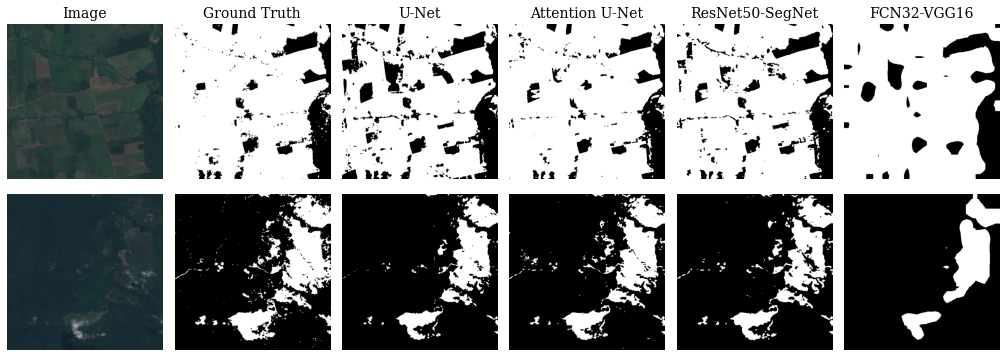

In [114]:
# Plot images, ground truths, and predictions side by side

fig, axs = plt.subplots(2, 6, figsize=(18,6))
axs[0, 0].imshow(im_1.reshape(512,512,3))
axs[1, 0].imshow(im_11.reshape(512,512,3))
axs[0, 1].imshow(mk_1.reshape(512,512), cmap='gray')
axs[1, 1].imshow(mk_11.reshape(512,512), cmap='gray')
axs[0, 2].imshow(ds_3d_unet_1, cmap='gray')
axs[1, 2].imshow(ds_3d_unet_2, cmap='gray')
axs[0, 3].imshow(ds_3d_attention_1, cmap='gray')
axs[1, 3].imshow(ds_3d_attention_2, cmap='gray')
axs[0, 4].imshow(ds_3d_resnet_1, cmap='gray')
axs[1, 4].imshow(ds_3d_resnet_2, cmap='gray')
axs[0, 5].imshow(ds_3d_fcn32_1, cmap='gray')
axs[1, 5].imshow(ds_3d_fcn32_2, cmap='gray')

# Remove axes
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')
axs[0,2].axis('off')
axs[1,2].axis('off')
axs[0,3].axis('off')
axs[1,3].axis('off')
axs[0,4].axis('off')
axs[1,4].axis('off')
axs[0,5].axis('off')
axs[1,5].axis('off')

# Set equal spacing
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')
axs[1,0].set_aspect('equal')
axs[1,1].set_aspect('equal')
axs[0,2].set_aspect('equal')
axs[1,2].set_aspect('equal')
axs[0,3].set_aspect('equal')
axs[1,3].set_aspect('equal')
axs[0,4].set_aspect('equal')
axs[1,4].set_aspect('equal')
axs[0,5].set_aspect('equal')
axs[1,5].set_aspect('equal')

# Set titles
axs[0,0].set_title('Image', size=14)
axs[0,1].set_title('Ground Truth', size=14)
axs[0,2].set_title('U-Net', size=14)
axs[0,3].set_title('Attention U-Net', size=14)
axs[0,4].set_title('ResNet50-SegNet', size=14)
axs[0,5].set_title('FCN32-VGG16', size=14)


#fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1)

### Image 1

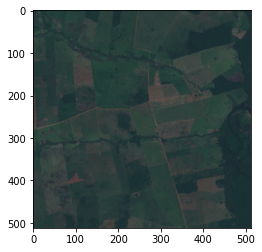

In [ ]:
# Original image
plt.imshow(im_1.reshape(512,512,3))

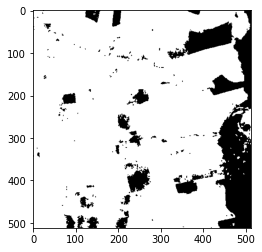

In [ ]:
# Ground truth mask
plt.imshow(mk_1.reshape(512,512), cmap = 'gray')

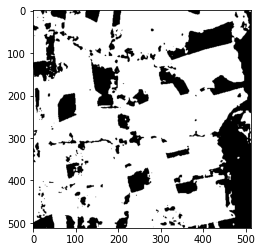

In [ ]:
# Construct prediction from U-Net
reconstruct_image(unet, im_1, rounded = True, cmap = 'gray')

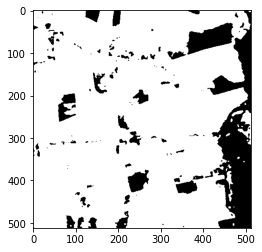

In [ ]:
# Construct prediction from Attention U-Net
reconstruct_image(attention_unet, im_1, rounded = True, cmap = 'gray')

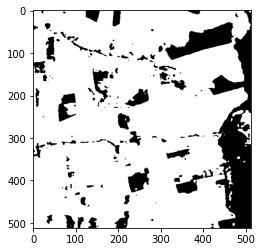

In [ ]:
# Construct prediction from ResNet50-SegNet
reconstruct_image(resnet_3d, im_1, rounded = True, cmap = 'gray')

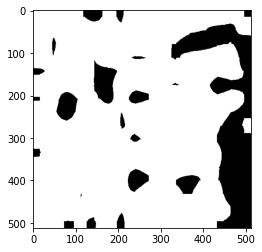

In [ ]:
# Construct prediction from FCN32-VGG16
reconstruct_image(fcn32_3d, im_1, rounded = True, cmap = 'gray')

## Comparison of 4-band Amazon data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


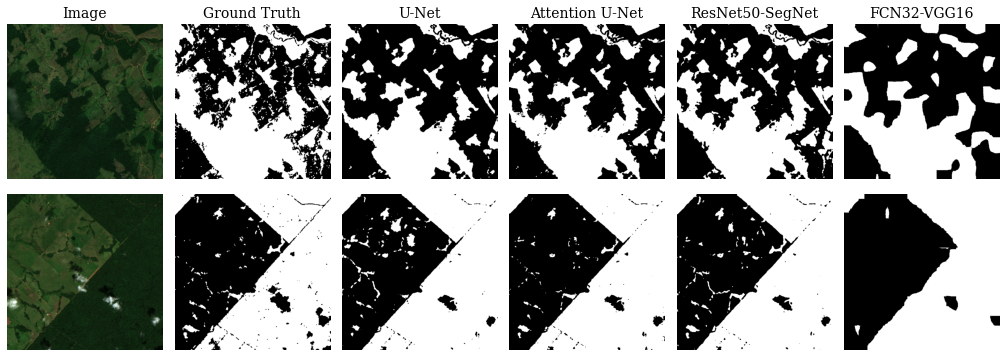

In [120]:
# Plot images, ground truths, and predictions side by side

fig, axs = plt.subplots(2, 6, figsize=(18,6))
axs[0, 0].imshow(2*im_2.reshape(512,512,4)[:,:,0:3]) # 2* image just to brighten it
axs[1, 0].imshow(2*im_22.reshape(512,512,4)[:,:,0:3]) # ""
axs[0, 1].imshow(mk_2.reshape(512,512), cmap='gray')
axs[1, 1].imshow(mk_22.reshape(512,512), cmap='gray')
axs[0, 2].imshow(ds_4d_unet_1, cmap='gray')
axs[1, 2].imshow(ds_4d_unet_2, cmap='gray')
axs[0, 3].imshow(ds_4d_attention_1, cmap='gray')
axs[1, 3].imshow(ds_4d_attention_2, cmap='gray')
axs[0, 4].imshow(ds_4d_resnet_1, cmap='gray')
axs[1, 4].imshow(ds_4d_resnet_2, cmap='gray')
axs[0, 5].imshow(ds_4d_fcn32_1, cmap='gray')
axs[1, 5].imshow(ds_4d_fcn32_2, cmap='gray')

# Remove axes
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')
axs[0,2].axis('off')
axs[1,2].axis('off')
axs[0,3].axis('off')
axs[1,3].axis('off')
axs[0,4].axis('off')
axs[1,4].axis('off')
axs[0,5].axis('off')
axs[1,5].axis('off')

# Set equal spacing
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')
axs[1,0].set_aspect('equal')
axs[1,1].set_aspect('equal')
axs[0,2].set_aspect('equal')
axs[1,2].set_aspect('equal')
axs[0,3].set_aspect('equal')
axs[1,3].set_aspect('equal')
axs[0,4].set_aspect('equal')
axs[1,4].set_aspect('equal')
axs[0,5].set_aspect('equal')
axs[1,5].set_aspect('equal')

# Set titles
axs[0,0].set_title('Image', size=14)
axs[0,1].set_title('Ground Truth', size=14)
axs[0,2].set_title('U-Net', size=14)
axs[0,3].set_title('Attention U-Net', size=14)
axs[0,4].set_title('ResNet50-SegNet', size=14)
axs[0,5].set_title('FCN32-VGG16', size=14)


#fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1)

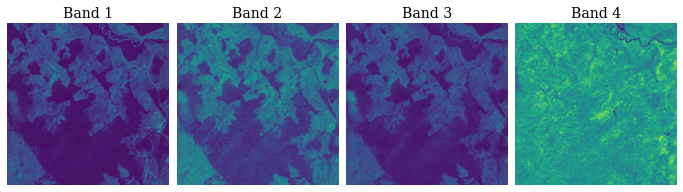

In [115]:
# Show different bands
fig, axs = plt.subplots(1,4, figsize=(12,6))
axs[0].imshow(im_2.reshape(512,512,4)[:,:,0])
axs[1].imshow(im_2.reshape(512,512,4)[:,:,1])
axs[2].imshow(im_2.reshape(512,512,4)[:,:,2])
axs[3].imshow(im_2.reshape(512,512,4)[:,:,3])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')

axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')
axs[3].set_aspect('equal')

axs[0].set_title('Band 1', size=14)
axs[1].set_title('Band 2', size=14)
axs[2].set_title('Band 3', size=14)
axs[3].set_title('Band 4', size=14)

fig.subplots_adjust(wspace=0.05, hspace=0)

### Image 1

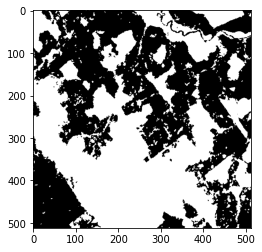

In [ ]:
# Ground truth mask
plt.imshow(mk_2.reshape(512,512), cmap = 'gray')

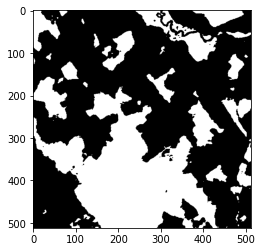

In [ ]:
# Construct prediction from U-Net
reconstruct_image(unet_4d, im_2, rounded = True, cmap = 'gray')

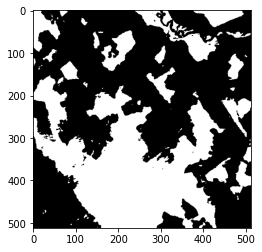

In [ ]:
# Construct prediction from Attention U-Net
reconstruct_image(attention_unet_4d, im_2, rounded = True, cmap = 'gray')

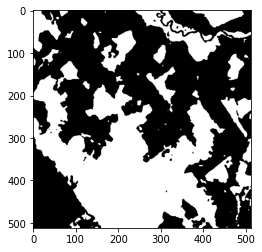

In [ ]:
# Construct prediction from ResNet50-SegNet
reconstruct_image(resnet_4d_amazon, im_2, rounded = True, cmap = 'gray')

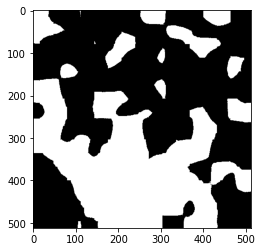

In [ ]:
# Construct prediction from FCN32-VGG16
reconstruct_image(fcn32_4d_amazon, im_2, rounded = True, cmap = 'gray')

## Comparison of 4-band Atlantic data

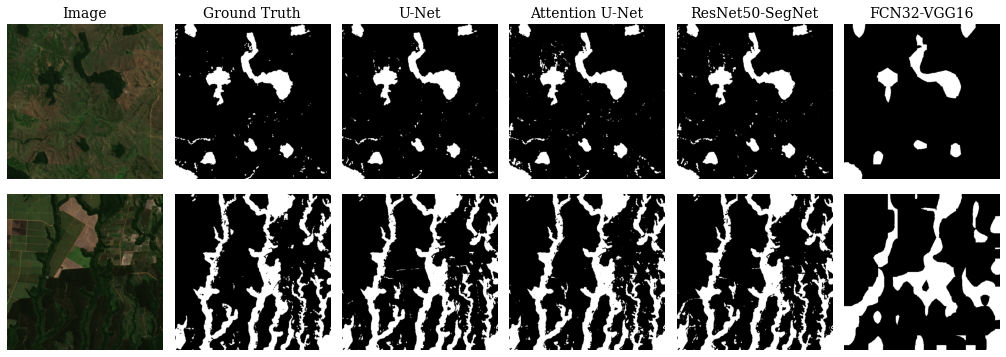

In [154]:
# Plot images, ground truths, and predictions side by side

fig, axs = plt.subplots(2, 6, figsize=(18,6))
axs[0, 0].imshow(2*im_3.reshape(512,512,4)[:,:,0:3]) # 2* image just to brighten it
axs[1, 0].imshow(2*im_33.reshape(512,512,4)[:,:,0:3]) # ""
axs[0, 1].imshow(mk_3.reshape(512,512), cmap='gray')
axs[1, 1].imshow(mk_33.reshape(512,512), cmap='gray')
axs[0, 2].imshow(ds_4d2_unet_1, cmap='gray')
axs[1, 2].imshow(ds_4d2_unet_2, cmap='gray')
axs[0, 3].imshow(ds_4d2_attention_1, cmap='gray')
axs[1, 3].imshow(ds_4d2_attention_2, cmap='gray')
axs[0, 4].imshow(ds_4d2_resnet_1, cmap='gray')
axs[1, 4].imshow(ds_4d2_resnet_2, cmap='gray')
axs[0, 5].imshow(ds_4d2_fcn32_1, cmap='gray')
axs[1, 5].imshow(ds_4d2_fcn32_2, cmap='gray')

# Remove axes
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')
axs[0,2].axis('off')
axs[1,2].axis('off')
axs[0,3].axis('off')
axs[1,3].axis('off')
axs[0,4].axis('off')
axs[1,4].axis('off')
axs[0,5].axis('off')
axs[1,5].axis('off')

# Set equal spacing
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')
axs[1,0].set_aspect('equal')
axs[1,1].set_aspect('equal')
axs[0,2].set_aspect('equal')
axs[1,2].set_aspect('equal')
axs[0,3].set_aspect('equal')
axs[1,3].set_aspect('equal')
axs[0,4].set_aspect('equal')
axs[1,4].set_aspect('equal')
axs[0,5].set_aspect('equal')
axs[1,5].set_aspect('equal')

# Set titles
axs[0,0].set_title('Image', size=14)
axs[0,1].set_title('Ground Truth', size=14)
axs[0,2].set_title('U-Net', size=14)
axs[0,3].set_title('Attention U-Net', size=14)
axs[0,4].set_title('ResNet50-SegNet', size=14)
axs[0,5].set_title('FCN32-VGG16', size=14)


#fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1)

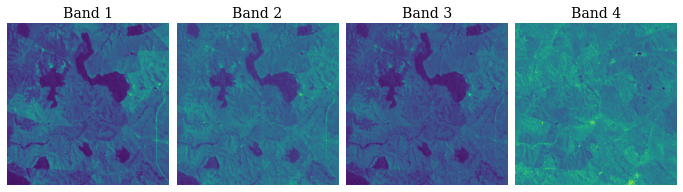

In [116]:
# Show different bands
fig, axs = plt.subplots(1,4, figsize=(12,6))
axs[0].imshow(im_3.reshape(512,512,4)[:,:,0])
axs[1].imshow(im_3.reshape(512,512,4)[:,:,1])
axs[2].imshow(im_3.reshape(512,512,4)[:,:,2])
axs[3].imshow(im_3.reshape(512,512,4)[:,:,3])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')

axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')
axs[3].set_aspect('equal')

axs[0].set_title('Band 1', size=14)
axs[1].set_title('Band 2', size=14)
axs[2].set_title('Band 3', size=14)
axs[3].set_title('Band 4', size=14)

fig.subplots_adjust(wspace=0.05, hspace=0)

### Image 1

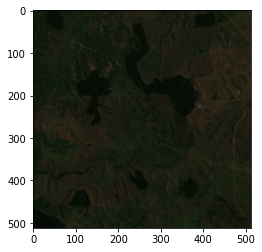

In [ ]:
# Original image
plt.imshow(im_3.reshape(512,512,4)[:,:,0:3])

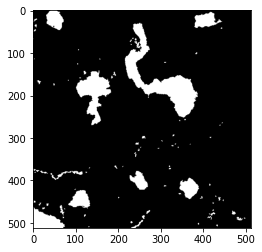

In [ ]:
# Ground truth mask
plt.imshow(mk_3.reshape(512,512), cmap = 'gray')

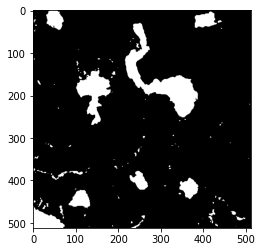

In [ ]:
# Construct prediction from U-Net
reconstruct_image(unet_4d_atlantic, im_3, rounded = True, cmap = 'gray')

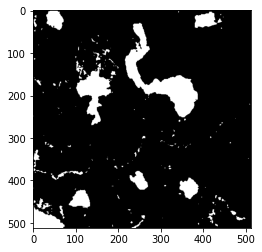

In [ ]:
# Construct prediction from Attention U-Net
reconstruct_image(attention_unet_4d_atlantic, im_3, rounded = True, cmap = 'gray')

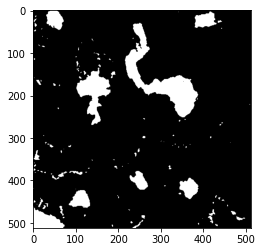

In [ ]:
# Construct prediction from ResNet50-SegNet
reconstruct_image(resnet_4d_atlantic, im_3, rounded = True, cmap = 'gray')

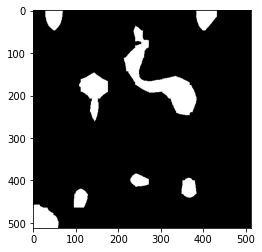

In [ ]:
# Construct prediction from FCN32-VGG16
reconstruct_image(fcn32_4d_atlantic, im_3, rounded = True, cmap = 'gray')

# Map of location of images

In [19]:
def convert_to_coordinates(image_path):
  rasterized_image = rasterio.open(image_path)
  boundary = rasterized_image.bounds
  l = boundary.left
  b = boundary.bottom
  r = boundary.right
  t = boundary.top

  return ((l+r)/2, (t+b)/2)

In [12]:
# Transformation matrix for coordinate system
file1 = 'AMAZON/Training/image/{}'.format(training_images_list2[0])
~rasterio.open(file1).transform

Affine(0.1, 0.0, -72556.0,
       0.0, -0.1, 871296.0)

In [15]:
# Extract coordinates of train images
# A lot of images have broken coordinates and give coordinates in Greenland and the Atlantic Ocean
amazon_coords = []
atlantic_coords = []

amazon_coords_train = []
for n in training_images_list2:
  data = gdal.Info('/content/AMAZON/Training/image/{}'.format(n), format='json')
  info = data['wgs84Extent']['coordinates'][0][4][::-1]
  if info[0] < 2:
    amazon_coords_train.append(info)
    amazon_coords.append(info)

  '''
  # Include broken coordinates by offsetting them w.r.t working coordinates  
  if info[0] > 2 and info[1] > -60:
    info[0] = info[0] - 77.5
    info[1] = info[1] - 9
  elif info[0] > 2 and info[1] < -60:
    info[0] = info[0] - 77.5
    info[1] = info[1]
  amazon_coords.append(info)
  '''

atlantic_coords_train = []
for n in training_images_list3:
  data = gdal.Info('/content/ATLANTIC FOREST/Training/image/{}'.format(n), format='json')
  info = data['wgs84Extent']['coordinates'][0][4][::-1]
  if info[0] > -18:
    atlantic_coords_train.append(info)
    atlantic_coords.append(info)

  '''
  # Include broken coordinates by offsetting them w.r.t working coordinates
  if info[0] < -18:
    info[0] = info[0] + 4
    info[1] = info[1] - 4
  atlantic_coords.append(info)
  '''

In [16]:
# Extract coordinates of validation images
# A lot of images have broken coordinates and give coordinates in Greenland and the Atlantic Ocean
amazon_coords_validation = []
for n in validation_images_list2:
  data = gdal.Info('/content/AMAZON/Validation/images/{}'.format(n), format='json')
  info = data['wgs84Extent']['coordinates'][0][4][::-1]
  if info[0] < 2:
    amazon_coords_validation.append(info)
    amazon_coords.append(info)

  '''
  # Include broken coordinates by offsetting them w.r.t working coordinates  
  if info[0] > 2 and info[1] > -60:
    info[0] = info[0] - 77.5
    info[1] = info[1] - 9
  elif info[0] > 2 and info[1] < -60:
    info[0] = info[0] - 77.5
    info[1] = info[1]
  amazon_coords.append(info)
  '''

atlantic_coords_validation = []
for n in validation_images_list3:
  data = gdal.Info('/content/ATLANTIC FOREST/Validation/images/{}'.format(n), format='json')
  info = data['wgs84Extent']['coordinates'][0][4][::-1]
  if info[0] > -18:
    atlantic_coords_validation.append(info)
    atlantic_coords.append(info)

  '''
  # Include broken coordinates by offsetting them w.r.t working coordinates
  if info[0] < -18:
    info[0] = info[0] + 4
    info[1] = info[1] - 4
  atlantic_coords.append(info)
  '''

In [17]:
# Extract coordinates of test images
# A lot of images have broken coordinates and give coordinates in Greenland and the Atlantic Ocean
amazon_coords_test = []
for n in test_images_list2:
  data = gdal.Info('/content/AMAZON/Test/image/{}'.format(n), format='json')
  info = data['wgs84Extent']['coordinates'][0][4][::-1]
  if info[0] < 2:
    amazon_coords_test.append(info)
    amazon_coords.append(info)

  '''
  # Include broken coordinates by offsetting them w.r.t working coordinates  
  if info[0] > 2 and info[1] > -60:
    info[0] = info[0] - 77.5
    info[1] = info[1] - 9
  elif info[0] > 2 and info[1] < -60:
    info[0] = info[0] - 77.5
    info[1] = info[1]
  amazon_coords.append(info)
  '''

atlantic_coords_test = []
for n in test_images_list3:
  data = gdal.Info('/content/ATLANTIC FOREST/Test/image/{}'.format(n), format='json')
  info = data['wgs84Extent']['coordinates'][0][4][::-1]
  if info[0] > -18:
    atlantic_coords_test.append(info)
    atlantic_coords.append(info)

  '''
  # Include broken coordinates by offsetting them w.r.t working coordinates
  if info[0] < -18:
    info[0] = info[0] + 4
    info[1] = info[1] - 4
  atlantic_coords.append(info)
  '''

In [18]:
map = folium.Map(location=[ 1.574822, -62.773457 ], zoom_start=5, tiles = 'cartodbpositron')
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
amazon_cluster = MarkerCluster().add_to(map)
atlantic_cluster = MarkerCluster().add_to(map)

# Draw images coordinates
for n in amazon_coords:
  #folium.CircleMarker(n, radius=10, weight=1, color='red', fill_color='red', fill_opacity=.05).add_to(map)
  folium.CircleMarker(n, radius=2, fill_opacity=0.25, fill_color='red', weight=2, color='red').add_to(map)
for n in atlantic_coords:
  #folium.CircleMarker(n, radius=10, weight=1, color='red', fill_color='red', fill_opacity=.05).add_to(map)
  folium.CircleMarker(n, radius=2, fill_opacity=0.25, fill_color='red', weight=2, color='red').add_to(map)


# Add heatmap of points
HeatMap(amazon_coords+atlantic_coords, radius=40, max_zoom=10, min_opacity=0.25).add_to(map)
#HeatMap(atlantic_coords, radius=40, max_zoom=10, min_opacity=0.25).add_to(map)
# Available parameters: HeatMap(data, name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=15, gradient=None, overlay=True, control=True, show=True)
map

In [482]:
map.save('map.html')

## Map showing where Amazon and Atlantic Forest is

@article{article,
author = {Oliveira-Ferreira, Joseli and Lacerda, Marcus and Brasil, Patrícia and Ladislau, José and Tauil, Pedro and Daniel-Ribeiro, Cláudio},
year = {2010},
month = {04},
pages = {115},
title = {Malaria in Brazil: An overview},
volume = {9},
journal = {Malaria journal},
doi = {10.1186/1475-2875-9-115}
}

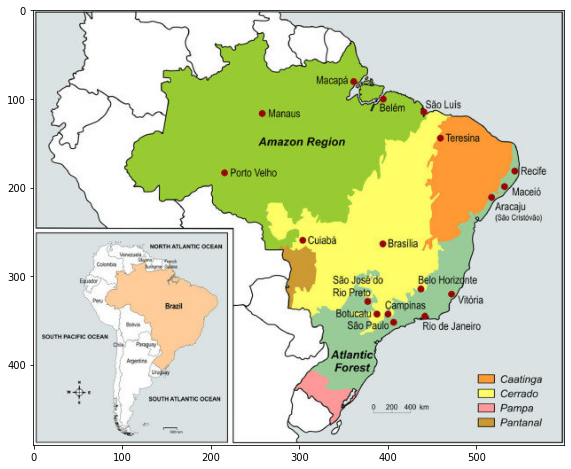

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(plt.imread('amazon-atlantic-forest-mapjpg.jpg'))

My own custom made map

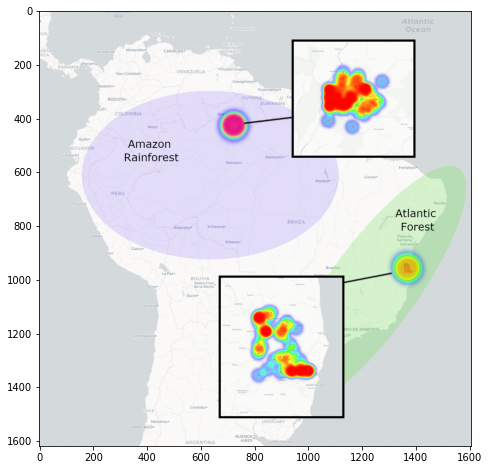

In [489]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(plt.imread('Amazon-Map.png'))